In [1]:
import requests
import re
from bs4 import BeautifulSoup
from pprint import pprint
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

## 1. 从北京地铁官网中下载北京地铁数据

In [2]:
def get_page(url, encoding='utf-8'):
    '''
    获取网页的 BeautifulSoup 对象
    '''
    try:
        response = requests.get(url)
        if response.status_code == 200:
            response.encoding = encoding
            return BeautifulSoup(response.text, 'html5lib')
    except resquests.ConnectionError as e:
        print('Error! ', e.args)


def parse_page(soup):
    '''
    解析网页，返回每条地铁线的站点，以及站点区间距离
    '''
    line_stations = {}
    range_distance = {}
    subway_map = {}
    table = soup.select('div[class="line_content"] > div[class="line_place"]')
    for line in table:
        head = line.select('thead > tr > td')[0].string
        line_name = re.match('(.*)相邻', head).group(1)
        body = line.select('tbody > tr')

        stations = [
            item.select('th')[0].string.split('——')[0] for item in body
        ]
        stations.append(body[-1].select('th')[0].string.split('——')[1])
        line_stations[line_name] = stations

        distance = {
            tuple(item.select('th')[0].string.split('——')): int(
                item.select('td')[0].string)
            for item in body
        }
        range_distance.update(distance)
        subway_map['line_stations'] = line_stations
        subway_map['range_distance'] = range_distance
    return subway_map

In [3]:
url = 'http://www.bjsubway.com/station/zjgls/#'
soup = get_page(url, encoding='gbk')

In [4]:
subway_map = parse_page(soup)

In [5]:
def show_dict(dict, k_count=3, v_count=5):
    count = 0
    for key, values in dict.items():
        count += 1
        print(key, ':', values)
        if count == k_count: break
    print('...')

In [6]:
show_dict(subway_map['line_stations'])

1号线 : ['苹果园', '古城', '八角游乐园', '八宝山', '玉泉路', '五棵松', '万寿路', '公主坟', '军事博物馆', '木樨地', '南礼士路', '复兴门', '西单', '天安门西', '天安门东', '王府井', '东单', '建国门', '永安里', '国贸', '大望路', '四惠', '四惠东']
2号线 : ['西直门', '车公庄', '阜成门', '复兴门', '长椿街', '宣武门', '和平门', '前门', '崇文门', '北京站', '建国门', '朝阳门', '东四十条', '东直门', '雍和宫', '安定门', '鼓楼大街', '积水潭', '西直门']
4号线 : ['安河桥北', '北宫门', '西苑', '圆明园', '北京大学东门', '中关村', '海淀黄庄', '人民大学', '魏公村', '国家图书馆', '动物园', '西直门', '新街口', '平安里', '西四', '灵境胡同', '西单', '宣武门', '菜市口', '陶然亭', '北京南站', '马家堡', '角门西', '公益西桥']
...


In [7]:
show_dict(subway_map['range_distance'], k_count=10)

('苹果园', '古城') : 2606
('古城', '八角游乐园') : 1921
('八角游乐园', '八宝山') : 1953
('八宝山', '玉泉路') : 1479
('玉泉路', '五棵松') : 1810
('五棵松', '万寿路') : 1778
('万寿路', '公主坟') : 1313
('公主坟', '军事博物馆') : 1172
('军事博物馆', '木樨地') : 1166
('木樨地', '南礼士路') : 1291
...


## 2. 对北京地铁数据进行处理，构建邻接表无向图

In [8]:
station_connection = defaultdict(list)
for s1, s2 in subway_map['range_distance'].keys():
    station_connection[s1].append(s2)
    station_connection[s2].append(s1)

In [9]:
show_dict(station_connection, k_count=10)

苹果园 : ['古城']
古城 : ['苹果园', '八角游乐园']
八角游乐园 : ['古城', '八宝山']
八宝山 : ['八角游乐园', '玉泉路']
玉泉路 : ['八宝山', '五棵松']
五棵松 : ['玉泉路', '万寿路']
万寿路 : ['五棵松', '公主坟']
公主坟 : ['万寿路', '军事博物馆', '莲花桥', '西钓鱼台']
军事博物馆 : ['公主坟', '木樨地', '白堆子', '北京西站']
木樨地 : ['军事博物馆', '南礼士路']
...


In [10]:
station_connection['宣武门']

['长椿街', '和平门', '西单', '菜市口']

###  北京市地铁路线图可视化（一）

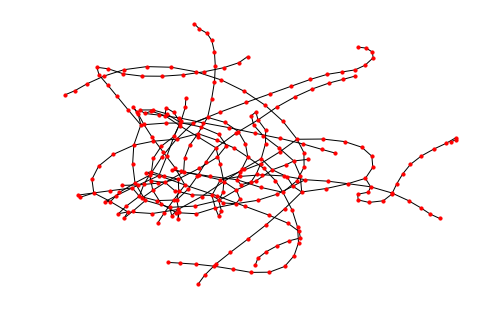

In [11]:
station_connection_graph = nx.Graph(station_connection)
nx.draw(station_connection_graph, with_labels=False, node_size=10)

### 北京市地铁路线图可视化（二）

由于缺少坐标数据，地铁路线图显得有点凌乱。使用爬虫从网络上爬取地铁站的经纬度信息，并可视化

In [12]:
loc_url = 'https://www.cnblogs.com/tianlin106/p/7007511.html'
loc_soup = get_page(loc_url, encoding='utf-8')
loc_text = loc_soup.select('p[class="p1"] > span[class="s1"]')[0]
loc_text = str(loc_text)
loc_text = re.sub('</span>', '', loc_text)
loc_text.split('|')[:3]

['<span class="s1">苹果园<span class="s2">,39.9263251384,116.1777806282',
 '<span class="s1">古城<span class="s2">,39.9072014648,116.1902475357',
 '<span class="s1">八角游乐园<span class="s2">,39.9074319023,116.2128210068']

In [13]:
station_loction = defaultdict(tuple)
stations = []
for line in loc_text.split('|'):
    res = re.match(r'.*"s1"\>(\w+)\<span.*"s2">,(\d+.\d+),\s?(\d+.\d+)', line)
    station = res.group(1)
    longitude = float(res.group(2))
    latitude = float(res.group(3))
    station_loction[station] = (longitude, latitude)
    stations.append(station)

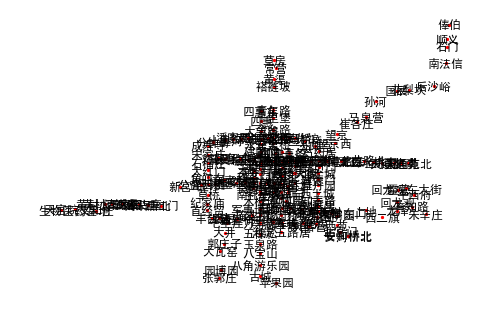

In [14]:
station_graph = nx.Graph()
station_graph.add_nodes_from(stations)
nx.draw(station_graph, station_loction, with_labels=True, node_size=5)

## 3. 北京市地铁路线规划

参考课堂上的代码，实现了北京市地铁路线规划

In [15]:
def is_goal(desitination):
    def _wrap(current_path):
        return current_path[-1] == desitination

    return _wrap


def search(graph, start, is_goal, search_stragegy, by_way=[]):
    '''
    param: graph: 邻接表无向图
    param: start: 起始站点
    param: is_goal: 判断是否到达终点站
    param: search_stragery: 搜索策略，目前实现：1.按路程最少优先 2.按换乘次数最少优先 3.综合优先（如：换乘次数相同情况下路程最少优先）
    param: by_way: list 需要中途经过的站点
    '''
    pathes = [[start]]
    seen = set()

    res = []

    while pathes:
        path = pathes.pop(0)
        front_iter = path[-1]

        if front_iter in seen:
            continue
        successor = graph[front_iter]
        for station in successor:
            if station in path:
                continue

            new_path = path + [station]
            pathes.append(new_path)

            if by_way == [] and is_goal(new_path):    # by_way 是空时，直接判断当前地铁站是否是终点
                res.extend(new_path)
                return res
            elif station in by_way:    # 如果 by_way 不为空，且当前地铁站是要经过的站点，将当前路径存入 res, 以当前站点为起点继续搜索
                res.extend(path)
                by_way.remove(station)
                pathes = []
                seen = set()
                pathes.append([station])

        seen.add(front_iter)
        pathes = search_stragegy(pathes)


def sort_path(cmp_func, subway_map=subway_map):
    '''
    param: cmp_func: 决定以搜索策略，若cmp_func是list，则综合优先
    param: subway_map: 地铁路线数据，包括站点名称，区间距离。 默认为北京市地铁路线数据
    '''
    if isinstance(cmp_func, list):

        def _sorted(pathes):
            return sorted(
                pathes, key=lambda path: [func(path) for func in cmp_func])
    else:

        def _sorted(pathes):
            return sorted(pathes, key=cmp_func)

    return _sorted


def get_path_distance(path, subway_map=subway_map):
    '''
    获取路径的距离
    '''
    distance = 0
    range_distance = subway_map['range_distance']
    for i, c in enumerate(path[:-1]):
        if (c, path[i + 1]) in range_distance.keys():
            distance += range_distance[(c, path[i + 1])]
        else:
            distance += range_distance[(path[i + 1], c)]
    return distance


def get_path_transfer_num(path):
    '''
    获取换乘次数
    '''
    return len(get_path_transfer(path))


def get_path_transfer(path, subway_map=subway_map):
    '''
    获取换乘路线
    '''
    line_stations = subway_map['line_stations']
    transfer = defaultdict(list)
    for i, c in enumerate(path[:-1]):
        for line, stations in line_stations.items():
            if (c in stations) and (path[i + 1] in stations):    # 根据路径中的连续站点判断地铁线路                
                transfer[line].append(c)
                transfer[line].append(path[i + 1])
    return transfer

### 结果展示

In [16]:
def show_path(path):
    res = ""
    transfer = get_path_transfer(path)
    for line, stations in transfer.items():
        start = stations[0]
        end = stations[-1]
        s = "🚇{}上车——{}——🚇{}下车\n".format(start, line, end)
        res += s
    return res

def show_distence(path):
    dis = get_path_distance(path)
    return '总路程{:.1f}公里'.format(dis/1000)

#### 最短路程优先

In [17]:
res1 = search(
    graph=station_connection,
    start='苏庄',
    is_goal=is_goal('北京站'),
    search_stragegy=sort_path(get_path_distance))
print(show_path(res1))
print(show_distence(res1))

🚇苏庄上车——房山线——🚇郭公庄下车
🚇郭公庄上车——9号线——🚇北京西站下车
🚇北京西站上车——7号线——🚇菜市口下车
🚇菜市口上车——4号线——🚇宣武门下车
🚇宣武门上车——2号线——🚇北京站下车

总路程44.2公里


In [18]:
res1 = search(
    graph=station_connection,
    start='北京西站',
    is_goal=is_goal('南锣鼓巷'),
    search_stragegy=sort_path(get_path_distance))
print(show_path(res1))
print(show_distence(res1))

🚇北京西站上车——9号线——🚇白石桥南下车
🚇白石桥南上车——6号线——🚇南锣鼓巷下车

总路程10.9公里


#### 与百度地图的时间最短优先结果对比
- 苏庄 至 北京站 路线**有所差异**，但是我们的路程较短


- 北京西站 至 南锣鼓巷 **结果相同**

**原因**： 由于我们的程序没有考虑用户换乘时的步行时间，在需要经过较多换乘时，误差就会累积变大

<img style="float:left;" src="./image/1.PNG" width="25%">  
<img style="float:center;" src="./image/2.PNG" width="25%">

#### 换乘次数最少优先

In [19]:
res2 = search(
    graph=station_connection,
    start='苏庄',
    is_goal=is_goal('石门'),
    search_stragegy=sort_path(get_path_transfer_num))
print(show_path(res2))
print(show_distence(res2))

🚇苏庄上车——房山线——🚇郭公庄下车
🚇郭公庄上车——9号线——🚇白石桥南下车
🚇白石桥南上车——6号线——🚇金台路下车
🚇金台路上车——14号线(西段)——🚇望京下车
🚇望京上车——15号线——🚇石门下车

总路程86.5公里


#### 与百度地图的时间少换乘优先结果对比
- 苏庄 至 石门 路线与和第二条推荐路线相同

<img style="float:left;" src="./image/3.PNG" width="25%">  

#### 综合优先

In [20]:
res3 = search(
    graph=station_connection,
    start='传媒大学',
    is_goal=is_goal('安河桥北'),
    search_stragegy=sort_path([get_path_transfer_num, get_path_distance]))
print(show_path(res3))
print(show_distence(res3))

🚇传媒大学上车——八通线——🚇四惠下车
🚇四惠东上车——1号线——🚇西单下车
🚇西单上车——4号线——🚇安河桥北下车

总路程34.5公里


#### 与百度地图的结果对比
- 路线一致

<img style="float:left;" src="./image/4.PNG" width="25%">  